In [2]:
import json
import numpy as np
import lmfit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from lmfit import Parameters, minimize, report_fit

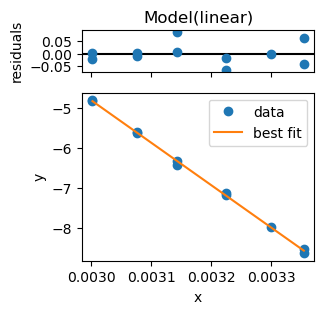

1321.5527460822657

In [3]:
temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['lnkdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)

# linear fit to get curve
model = lmfit.models.LinearModel()
params = model.make_params()
deg_result = model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])
deg_result.plot(fig_kws={'figsize': (3, 3)})
plt.show()

# get slope and intercept
slope = deg_result.params['slope'].value
intercept = deg_result.params['intercept'].value

def get_kdeg(temp, slope=slope, intercept=intercept):
    
    return np.exp(slope / (temp + 273.15) + intercept)

1 / get_kdeg(37)

In [4]:
def fmod_model(x, log_kappa, log_kdeg, log_fmod_0):
    kappa = np.exp(log_kappa)
    kdeg = np.exp(log_kdeg)
    fmod_0 = np.exp(log_fmod_0)
    return 1 - np.exp(- (kappa) * (1 - np.exp(-kdeg * x))) + fmod_0

def free_fit(df, temp, global_kdeg = None):
    site_nt = df['site'].astype(str).values[0] + df['base'].values[0]
    x_data = df['reaction_time'] * df['treated']
    y_data = df['fmod_val']

    #plt.scatter(x_data, y_data)
    #plt.show()
    # Create an lmfit model
    model = lmfit.Model(fmod_model)

    kdeg0 = get_kdeg(temp)
    kappa0 = -np.log(1 - y_data.max())
    fmod_00 = max(y_data.min(), 1e-6)  # Avoid log(0) errors
    
    params = model.make_params(
        log_kappa=np.log(kappa0), 
        log_kdeg=np.log(kdeg0), 
        log_fmod_0=np.log(fmod_00)
    )
    
    if global_kdeg is not None:
        # this value is log already
        params['log_kdeg'].set(value=global_kdeg, vary=False)

    # No constraints needed since we fit in log space
    result = model.fit(y_data, params, x=x_data)
    
    # # Remove outlier outside of 1.5σ and refit
    outlier = np.abs(result.residual) > 150 * np.std(result.residual)
    
    if sum(outlier) > 0:
        x_data = x_data[~outlier]
        y_data = y_data[~outlier]
    
        # Initial values = values from previous fit
        params = model.make_params(
            log_kappa=result.best_values['log_kappa'], 
            log_kdeg=result.best_values['log_kdeg'], 
            log_fmod_0=result.best_values['log_fmod_0']
        )
        
        result = model.fit(y_data, params, x=x_data)

    return result, site_nt, outlier

,site,log_kappa,log_kdeg,log_fmod_0,r2
0,2,4.510403,-17.585896,-7.177607,0.822772
1,3,-7.966141,-3.749757,-7.332796,0.739717
2,7,-3.716914,-3.974909,-6.760269,0.994133
3,8,-3.796539,-4.158431,-6.078175,0.991717
4,9,-3.535726,-3.991515,-5.863822,0.989038
5,15,-3.629093,-3.946374,-8.247465,0.993334
6,16,-3.833247,-4.112111,-6.428988,0.996980
7,17,-6.920463,-1.688879,-7.256464,0.853081
8,18,-3.838505,-3.992241,-6.547466,0.997519
9,22,-3.591926,-3.941113,-6.175468,0.995427


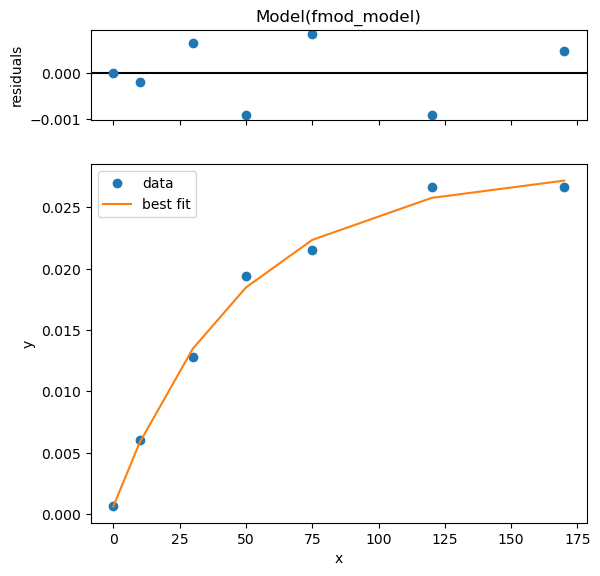

In [17]:
db_path = '/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(db_path)
# Execute the query with the provided parameters
rg_ids = list(pd.read_sql("SELECT DISTINCT rg.rg_id FROM reaction_groups rg;", conn)['rg_id'])
conn.close()

# Define the query to get fmod_val and reaction_time with a join between the necessary tables
query = """
    SELECT fv.fmod_val, pr.reaction_time, n.site, n.base, pr.treated, fv.read_depth, pr.RT, fv.valtype, pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM probing_reactions pr
    JOIN fmod_vals fv ON pr.id = fv.rxn_id
    JOIN nucleotides n ON fv.nt_id = n.id
    JOIN constructs c ON pr.construct_id = c.id
    JOIN sequencing_samples ss ON pr.s_id = ss.id
    JOIN reaction_groups rg ON rg.rxn_id = pr.id
    JOIN sequencing_runs sr on ss.seqrun_id = sr.id
    WHERE rg.rg_id = ?
    AND pr.reaction_time IN (
        SELECT pr2.reaction_time
        FROM probing_reactions pr2
        GROUP BY pr2.reaction_time
        HAVING COUNT(DISTINCT pr2.id) > 1
    )
    AND fv.fmod_val IS NOT NULL
    AND pr.RT = 'MRT'
    AND fv.valtype = 'modrate'
"""

store_results = []
resids_free = []
rsq_thres = 0.6

rg_id = 43

conn = sqlite3.connect(db_path)
rg_df = pd.read_sql(query, conn, params=(rg_id,))
conn.close()
rg_df['reaction_time'] = rg_df['reaction_time'] * rg_df['treated']
# sort
rg_df = rg_df.sort_values(['site', 'reaction_time'])

sites = rg_df['site'].unique()
for site in sites:
    site_df = rg_df[rg_df['site'] == site]
    temp = site_df['temperature'].values[0]

    try:
        fit_result, site_nt, outliers = free_fit(site_df, temp)
        if fit_result.rsquared > rsq_thres:
            store_results.append([site, fit_result.best_values['log_kappa'], fit_result.best_values['log_kdeg'], fit_result.best_values['log_fmod_0'], fit_result.rsquared])
            resids_free.append(fit_result.residual)
        if site == 29:
            fit_result.plot()
    except:
        continue

free_fits_results = pd.DataFrame(store_results, columns=['site', 'log_kappa', 'log_kdeg', 'log_fmod_0', 'r2'])
free_fits_results

,site,log_kappa,log_kdeg,log_fmod_0,r2
0,2,-8.068571,-3.96609,-7.224978,0.638911
1,3,-7.941069,-3.96609,-7.315744,0.732705
2,7,-3.718441,-3.96609,-6.783756,0.994125
3,8,-3.837634,-3.96609,-6.313042,0.987765
4,9,-3.540231,-3.96609,-5.896609,0.988961
5,15,-3.625799,-3.96609,-8.020545,0.993290
6,16,-3.862864,-3.96609,-6.684401,0.994761
7,18,-3.843127,-3.96609,-6.597562,0.997444
8,22,-3.587779,-3.96609,-6.134059,0.995355
9,25,-3.357996,-3.96609,-6.456739,0.995783


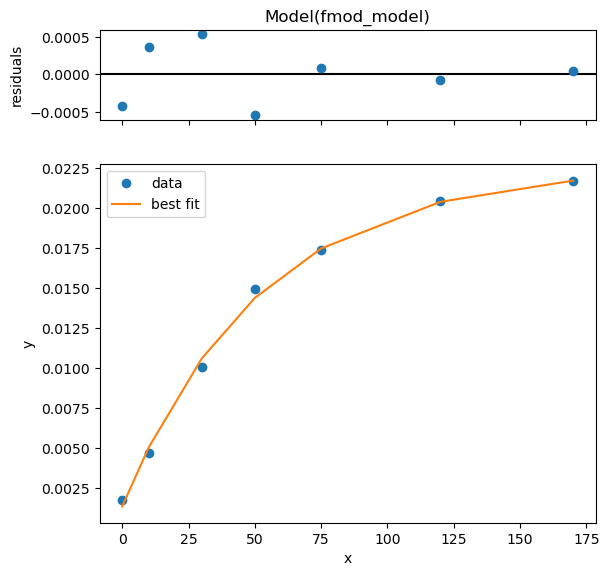

In [11]:
# Create parameters
def create_params(free_fit_results):
    fit_params = Parameters()

    log_kdeg_global = free_fit_results['log_kdeg'].mean()

    # iterrate rows of free_fit_results
    for i, row in free_fits_results.iterrows():
        site = row['site']
        log_kappa = row['log_kappa']
        log_fmod_0 = row['log_fmod_0']
        
        fit_params.add(f'log_kappa_{i+1}', value = log_kappa)
        fit_params.add(f'log_kdeg_{i+1}', value = log_kdeg_global)
        fit_params.add(f'log_fmod0_{i+1}', value = log_fmod_0)
        if i > 0:
            fit_params[f'log_kdeg_{i+1}'].expr = 'log_kdeg_1'
    return fit_params

# Create dataset
def create_dataset(free_fit_results, rg_df):
    sites = free_fit_results['site']
    data = []
    for site in sites:
        site_df = rg_df[rg_df['site'] == site].copy()
        site_df['reaction_time'] = site_df['reaction_time'] * site_df['treated']
        site_df = site_df.sort_values(['site', 'reaction_time'])

        x_data = site_df['reaction_time']
        y_data = site_df['fmod_val']
        data.append(y_data)
    return x_data, np.array(data)

# Define the dataset function using log-transformed parameters
def fmod_dataset(params, i, x):
    """Calculate fmod from parameters for data set."""
    log_kappa = params[f'log_kappa_{i+1}']
    log_kdeg = params[f'log_kdeg_{i+1}']
    log_fmod0 = params[f'log_fmod0_{i+1}']
    return fmod_model(x, log_kappa, log_kdeg, log_fmod0)

# Define the objective function
def objective(params, x, data):
    """Calculate total residual for fits of fmod_model to several data sets."""
    ndata, _ = data.shape
    resid = np.zeros_like(data)

    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - fmod_dataset(params, i, x)

    # Flatten residuals to a 1D array for optimization
    return resid.flatten()

def calculate_global_kdeg(free_fits_results, rg_df):
    global_params = create_params(free_fits_results)
    x_data, y_dataset = create_dataset(free_fits_results, rg_df)
    try:
        out = minimize(objective, global_params, args=(x_data, y_dataset))
    except:
        print('Global fitting failed')
        return None
    return out.params['log_kdeg_1'].value

median_kdeg = free_fits_results['log_kdeg'].median()
std_kdeg = free_fits_results['log_kdeg'].std()
filtered_datasets = free_fits_results[
    (free_fits_results['log_kdeg'] > median_kdeg - 2 * std_kdeg) & 
    (free_fits_results['log_kdeg'] < median_kdeg + 2 * std_kdeg)
]

global_kdeg = calculate_global_kdeg(filtered_datasets, rg_df)

store_results = []
resids = []
sites = rg_df['site'].unique()
for site in sites:
    site_df = rg_df[rg_df['site'] == site]
    temp = site_df['temperature'].values[0]
    try:
        fit_result, site_nt, outliers = free_fit(site_df, temp, global_kdeg)
        if fit_result.rsquared > rsq_thres:
            store_results.append([site, fit_result.best_values['log_kappa'], fit_result.best_values['log_kdeg'], fit_result.best_values['log_fmod_0'], fit_result.rsquared])
            if site == 18:
                fit_result.plot()
            resids.append(fit_result.residual)
    except:
        continue

global_refit_results = pd.DataFrame(store_results, columns=['site', 'log_kappa', 'log_kdeg', 'log_fmod_0', 'r2'])
global_refit_results

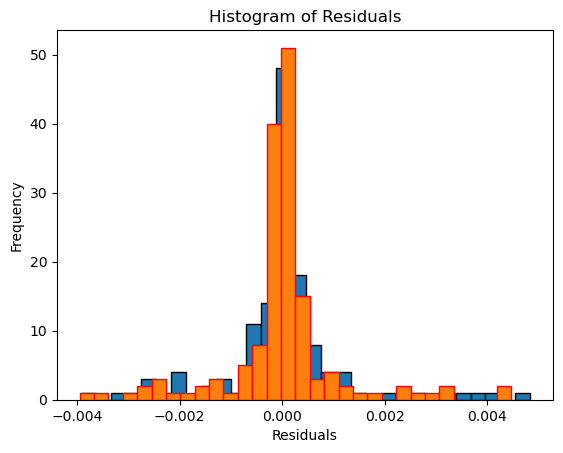

In [35]:
# Flatten the residuals
flattened_resids = np.concatenate(resids).flatten()
flattened_resids_free = np.concatenate(resids_free).flatten()

# Plot histogram
plt.hist(flattened_resids, bins=30, edgecolor='k')
plt.hist(flattened_resids_free, bins=30, edgecolor='r')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [31]:
from scipy.stats import shapiro

stat, p = shapiro(np.log(flattened_resids))
print(f"Shapiro-Wilk test statistic: {stat}, p-value: {p}")

Shapiro-Wilk test statistic: nan, p-value: nan


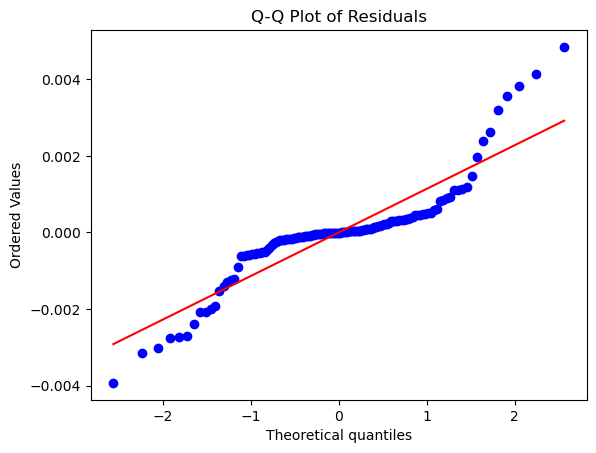

In [28]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(flattened_resids, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

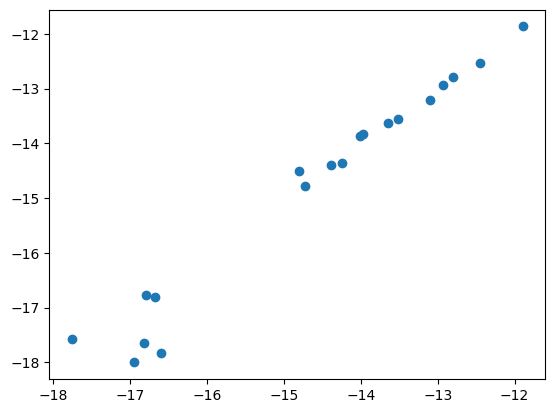

In [ ]:
merged = global_refit_results.merge(free_fits_results, on='site', suffixes=('_global', '_local'))
merged['kobs_global'] = np.exp(merged['log_kappa_global']) * np.exp(merged['log_kdeg_global'])
merged['kobs_local'] = np.exp(merged['log_kappa_local']) * np.exp(merged['log_kdeg_local'])

# plot kobs
plt.scatter(np.log(merged['kobs_global']), np.log(merged['kobs_local']))

In [ ]:
global_refit_results

,site,log_kappa,log_kdeg,log_fmod_0,r2
0,3,-7.365469,-9.582548,-7.363293,0.810659
1,7,-3.347596,-9.582548,-6.520051,0.970459
2,8,-3.518754,-9.582548,-6.367000,0.960641
3,9,-4.066003,-9.582548,-5.671468,0.960878
4,15,-4.386370,-9.582548,-7.067384,0.991459
5,16,-4.803658,-9.582548,-6.700023,0.989116
6,18,-2.314691,-9.582548,-5.933684,0.991883
7,19,-7.211663,-9.582548,-7.439044,0.888527
8,20,-7.012721,-9.582548,-6.660839,0.697116
9,21,-7.235373,-9.582548,-6.994836,0.695714


: 